In [8]:
rm(list = ls())
source("utilities.R") # using function getFRED() in utilities.R

# Load time series library
# Load required packages and source all programs to be used in HLW estimation.
if (!require("tis")) {install.packages("tis"); library("tis")} # Time series package # nolint
if (!require("mFilter")) {install.packages("mFilter"); library("mFilter")} # HP filter # nolint
if (!require("nloptr")) {install.packages("nloptr"); library("nloptr")} # Optimization # nolint

# 1. Prepare Input Data

In [9]:
# Set the start and end dates of the estimation sample (format is c(year,quarter))
data.start <- c(1987,1) 
data.end   <- c(2024,3)
sample.end <- data.end 

# The estimation process uses data beginning 4 quarters prior to the sample start
sample.start    <- shiftQuarter(data.start,4)

In [10]:
data.in <- read.table('/Users/yeonsoo/My Drive/Project/rstar/code/data/kor_input_250409.csv',
                    sep = ',', na.strings = ".",  header=TRUE, stringsAsFactors=FALSE)

In [11]:
# Set the inflation and interest rate data
inf <- 'ALL' # ALL, CORE, EX
int <- 'CALL' # CALL, CD, TA, LB, X1Y

In [12]:
gdp.log <- tis(data.in['log.GDP'], start=c(1960,1), end=data.end, tif='quarterly')
inflation <- tis(data.in[inf], start=c(1960,1), end=data.end, tif='quarterly')
inflation.expectations <- (inflation + Lag(inflation, k=1) + Lag(inflation, k=2) + Lag(inflation, k=3))/4 # MA(4)
interest <- tis(data.in[int], start=c(1960,1), end=data.end, tif='quarterly')

In [13]:
data.out <- window(cbind(gdp.log, inflation, inflation.expectations, interest),start = data.start, end = data.end) 
colnames(data.out) <- c('gdp.log', 'inflation', 'inflation.expectations', 'interest')

# 2. Define Model: the sample period, constraints, and variables
* Relaxed New Keynesian framework 
    * (1) IS Curve
    $$ \tilde{y}_t = a_{y,1} \tilde{y}_{t-1} +  a_{y,2} \tilde{y}_{t-2} +\frac{a_r}{2} \Sigma^{2}_{j=1} (r_{t-j}-r^*_{t-j}) + \epsilon_{\tilde{y}, t}$$

    * (2) Philips Curve
    $$ \pi_t = b_{\pi} \pi_{t-1} + (1-b_{\pi})\pi_{t-2, 4} +  b_{y} \tilde{y}_{t-1} + \epsilon_{\pi, t} $$

* Neoclassical growth model
$$
r_t^* = g_t + z_t \\

y_t^* = y_{t-1}^* + g_{t-1} + \epsilon_{y^*, t} \\ g_t = g_{t-1} + \epsilon_{g,t} \\ z_t = z_{t-1} + \epsilon_{z,t}

$$

### 2.1 Parameter constraints
* Set upper bound on a_3 parameter (slope of the IS curve $a_r$)
* Set lLower bound on b_2 parameter (slope of the Phillips curve $b_y$)
* These are minimal priors on the structure of the model that, in the event, facilitate the convergence of the numerical optimization during estimation. 

In [14]:
# Upper bound on a_3 parameter (slope of the IS curve)
a3.constraint <- -0.0025

# Lower bound on b_2 parameter (slope of the Phillips curve)
b2.constraint <- 0.025

### 2.2 Time period

In [15]:
# Set start index for y = 2
# ti: time index objects
g.pot.start.index <- 1 + ti(shiftQuarter(sample.start,-3),'quarterly')-ti(data.start,'quarterly') # nolint

### 2.3 Set other variables

In [16]:
# Set column names for CSV output
output.col.names <- c("Date","rstar","g","z","output gap","","All results are output from the Stage 3 model.",rep("",8),"Standard Errors","Date","y*","r*","g","","rrgap")

In [17]:
# Set number of iterations for Monte Carlo standard error procedure
niter <- 5000

In [18]:
# Because the MC standard error procedure is time consuming, we include a run switch
# Set run.se to TRUE to run the procedure
run.se <- TRUE

# 3. Estimation

In [19]:
# Get R file with basic functions
source("utilities.R")
source("calculate.covariance.R")
source("format.output.R")
source("kalman.log.likelihood.R")
source("kalman.standard.errors.R")
source("kalman.states.R")
source("kalman.states.wrapper.R")
source("log.likelihood.wrapper.R")

## Input data
* (1) Log output
* (2) Inflation
* (3) Real short-term interest rates 
* (4) Nominal short-term interest rates = Real short-term interest rates - Inflation expectations (MA(4))

In [20]:
kor.data <- as.data.frame(data.out)

In [21]:
kor.data <- as.data.frame(data.out)
library(dplyr)
kor.data <- kor.data %>%
    filter(!is.na(inflation.expectations))
kor.data <- kor.data %>%
    filter(!is.na(interest))

log.output             <- kor.data$gdp.log 
inflation              <- kor.data$inflation # annualized inflation rate 
inflation.expectations <- kor.data$inflation.expectations # 4-quarters MA (t, t-1, t-2, t-3) 
nominal.interest.rate  <- kor.data$interest 
real.interest.rate     <- nominal.interest.rate - inflation.expectations # nominal - inflation_expectation 


Attaching package: 'dplyr'


The following object is masked from 'package:tis':

    between


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




## State-Space Models form
$$
\begin{align}
y_t &= A' \cdot x_t + H' \cdot \xi_t + v_t \\
\xi_t &= F \cdot \xi_{t-1} + \varepsilon_t
\end{align}
$$

## 3.1 Stage 1
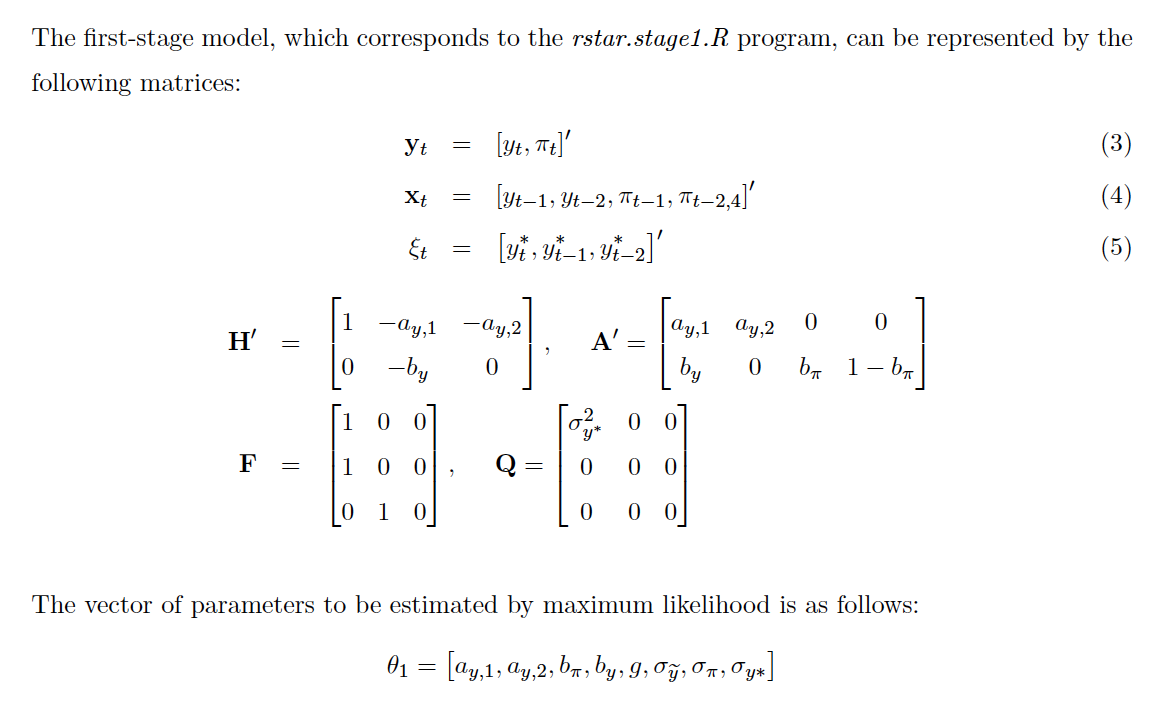
- Follow [Kuttner(1994)](https://www.notion.so/Measuring-the-natural-rate-of-interest-International-trends-and-determinants-3cbffc4cf24544c1aa9c71a421452c61?pvs=21), apply the Kalman filter to estimate the natural rate of output, omitting the real rate gap term from IS equation and assuming the trend growth rate  $g$ as a constant.
- Compute the exponential Wald statistic for a structural break with `unknown break` date from the first difference of this preliminary estimate of the natural rate of output, **obtain the median unbiased esimate $\lambda_g$.**

In [22]:
source("unpack.parameters.stage1.R") 
source("median.unbiased.estimator.stage1.R")

In [23]:
rstar.stage1 <- function(log.output,
                         inflation,
                         b2.constraint=NA) {

  stage <- 1
  
  # Data must start 4 quarters before the estimation period
  T <- length(log.output) - 4

  # Original output gap estimate
  x.og <- cbind(rep(1,T+4), 1:(T+4))
  y.og <- log.output
  output.gap <- (y.og - x.og %*% solve(t(x.og) %*% x.og, t(x.og) %*% y.og)) * 100

  # Initialization of state vector for Kalman filter using HP trend of log output
  log.output.hp.trend <- hpfilter(log.output,freq=36000,type="lambda",drift=FALSE)$trend
  g.pot <- log.output.hp.trend[(g.pot.start.index):length(log.output.hp.trend)]
  xi.00 <- c(100*g.pot[3:1])

  # IS curve
  y.is <- output.gap[5:(T+4)]
  x.is <- cbind(output.gap[4:(T+3)], output.gap[3:(T+2)])
  b.is <- solve(t(x.is) %*% x.is, t(x.is) %*% y.is)
  r.is <- y.is - x.is %*% b.is
  s.is <- sqrt(sum(r.is^2) / (length(r.is)-(dim(x.is)[2])))

  # Phillips curve
  y.ph <- inflation[5:(T+4)]
  x.ph <- cbind(inflation[4:(T+3)],
                (inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/3,
                output.gap[4:(T+3)])                
  b.ph <- solve(t(x.ph) %*% x.ph, t(x.ph) %*% y.ph)
  r.ph <- y.ph - x.ph %*% b.ph
  s.ph <- sqrt(sum(r.ph^2) / (length(r.ph)-(dim(x.ph)[2])))
  
  y.data <- cbind(100 * log.output[5:(T+4)],
                  inflation[5:(T+4)])
  x.data <- cbind(100 * log.output[4:(T+3)],
                  100 * log.output[3:(T+2)],
                  inflation[4:(T+3)],
                  (inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/3)

  # Starting values for the parameter vector
  initial.parameters <- c(b.is, b.ph[1], b.ph[3], 0.85, s.is, s.ph, 0.5)

  # Set an upper and lower bound on the parameter vectors:
  # The vector is unbounded unless values are otherwise specified
  theta.lb <- c(rep(-Inf,length(initial.parameters)))
  theta.ub <- c(rep(Inf,length(initial.parameters)))
  
  # Set a lower bound for the Phillips curve slope (b_2) of b2.constraint, if not NA
  # In HLW, b2.constraint = 0.025
  if (!is.na(b2.constraint)) {
      if (initial.parameters[4] < b2.constraint) {
          initial.parameters[4] <- b2.constraint
      }
      theta.lb[4] <- b2.constraint
  }

  # Set the initial covariance matrix (see footnote 6) 
  P.00 <- calculate.covariance(initial.parameters, theta.lb, theta.ub, y.data, x.data, stage, NA, NA, xi.00)
  
  # Get parameter estimates via maximum likelihood
  f <- function(theta) {return(-log.likelihood.wrapper(theta, y.data, x.data, stage, NA, NA, xi.00, P.00)$ll.cum)}
  nloptr.out <- nloptr(initial.parameters, f, eval_grad_f=function(x) {gradient(f, x)},
                       lb=theta.lb,ub=theta.ub,
                       opts=list("algorithm"="NLOPT_LD_LBFGS","xtol_rel"=1.0e-8))
  theta <- nloptr.out$solution

  log.likelihood <- log.likelihood.wrapper(theta, y.data, x.data, stage, NA, NA, xi.00, P.00)$ll.cum

  # Get state vectors (xi.tt, xi.ttm1, xi.tT, P.tt, P.ttm1, P.tT) via Kalman filter
  states <- kalman.states.wrapper(theta, y.data, x.data, stage, NA, NA, xi.00, P.00)

  # One-sided (filtered) estimates  
  potential.filtered  <- states$filtered$xi.tt[,1]/100
  output.gap.filtered <- y.data[,1] - (potential.filtered * 100)
  
  # Two-sided (smoothed) estimates
  potential.smoothed  <- as.vector(states$smoothed$xi.tT[,1])/100
  output.gap.smoothed <- y.data[,1] - (potential.smoothed * 100)

  # Save variables to return
  return.list                <- list()
  return.list$theta          <- theta
  return.list$log.likelihood <- log.likelihood
  return.list$states         <- states
  return.list$xi.00          <- xi.00
  return.list$P.00           <- P.00
  return.list$potential.filtered  <- potential.filtered
  return.list$output.gap.filtered <- output.gap.filtered
  return.list$potential.smoothed  <- potential.smoothed
  return.list$output.gap.smoothed <- output.gap.smoothed
  return(return.list)
}

In [24]:
# Running the stage 1 model
out.stage1 <- rstar.stage1(log.output,
      inflation,
      b2.constraint)

In [25]:
# Median unbiased estimate of lambda_g
lambda.g <- median.unbiased.estimator.stage1(out.stage1$potential.smoothed)

In [26]:
lambda.g

[1] 0.1359973

## 3.2 Stage 2
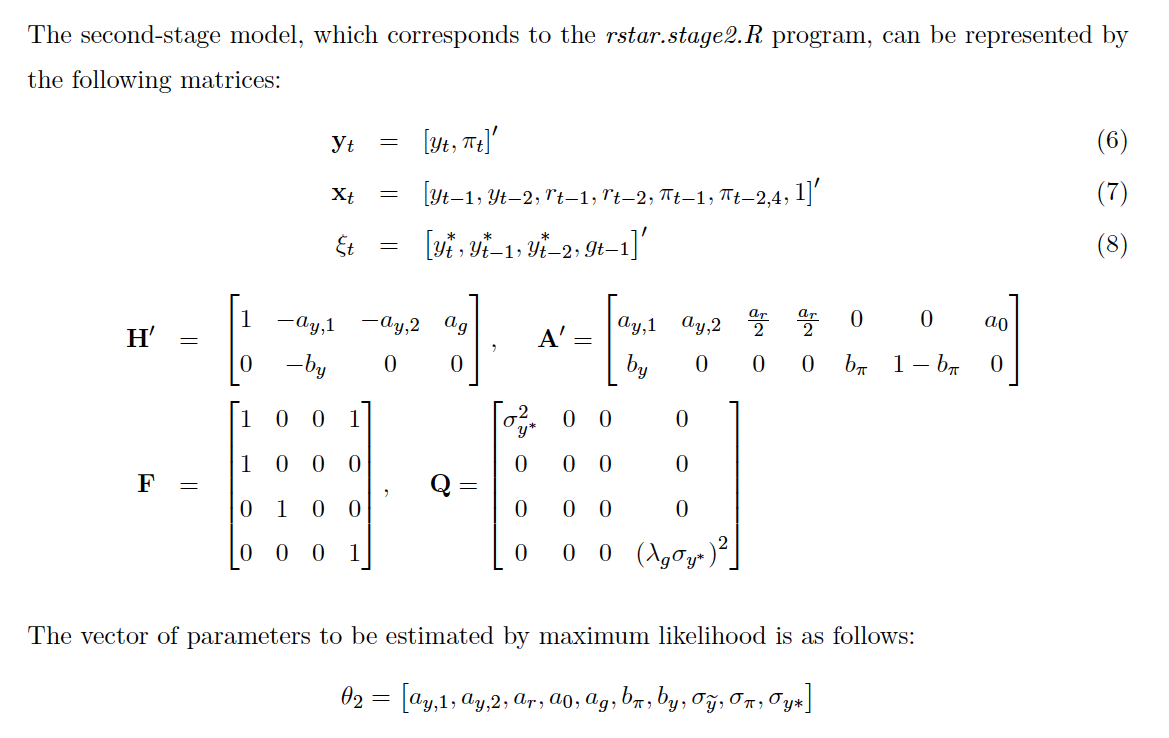

- Impose the estimated value of $\lambda_g$ from the first step and include the real interest rate gap in the output gap under the assumption that $z$ is constant.
- Estimate the five model equations and apply the exponential Wald test for an intercept shift in the IS equation at an unknown date to **obtain an estimate of $\lambda_z$.**

In [27]:
source("unpack.parameters.stage2.R") 
source("median.unbiased.estimator.stage2.R")

In [28]:
rstar.stage2 <- function(log.output,
                         inflation,
                         real.interest.rate,
                         lambda.g,
                         a3.constraint=NA,
                         b2.constraint=NA) {
                         
  stage <- 2

  # Data must start 4 quarters before the estimation period  
  T <- length(log.output) - 4

  # Original output gap estimate
  x.og <- cbind(rep(1,T+4), 1:(T+4))
  y.og <- log.output
  output.gap <- (y.og - x.og %*% solve(t(x.og) %*% x.og, t(x.og) %*% y.og)) * 100

  # Initialization of state vector for Kalman filter using HP trend of log output
  log.output.hp.trend <- hpfilter(log.output,freq=36000,type="lambda",drift=FALSE)$trend
  g.pot <- log.output.hp.trend[(g.pot.start.index):length(log.output.hp.trend)]
  g.pot.diff <- diff(g.pot)
  xi.00 <- c(100*g.pot[3:1],100*g.pot.diff[2])

  # IS curve
  y.is <- output.gap[5:(T+4)]
  x.is <- cbind(output.gap[4:(T+3)], output.gap[3:(T+2)],
                (real.interest.rate[4:(T+3)] + real.interest.rate[3:(T+2)])/2,
                rep(1,T))
  b.is <- solve(t(x.is) %*% x.is, t(x.is) %*% y.is)
  r.is <- as.vector(y.is - x.is %*% b.is)
  s.is <- sqrt(sum(r.is^2) / (length(r.is)-(dim(x.is)[2])))

  # Phillips curve
  y.ph <- inflation[5:(T+4)]
  x.ph <- cbind(inflation[4:(T+3)],
                (inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/3,
                output.gap[4:(T+3)])
  b.ph <- solve(t(x.ph) %*% x.ph, t(x.ph) %*% y.ph)
  r.ph <- y.ph - x.ph %*% b.ph
  s.ph <- sqrt(sum(r.ph^2) / (length(r.ph)-(dim(x.ph)[2])))
  
  y.data <- cbind(100 * log.output[5:(T+4)],
                  inflation[5:(T+4)])
  x.data <- cbind(100 * log.output[4:(T+3)],
                  100 * log.output[3:(T+2)],
                  real.interest.rate[4:(T+3)],
                  real.interest.rate[3:(T+2)],                  
                  inflation[4:(T+3)],
                  (inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/3,
                  rep(1,T))

  # Starting values for the parameter vector
  initial.parameters <- c(b.is, -b.is[3], b.ph[1], b.ph[3], s.is, s.ph, 0.5)

  # Set an upper and lower bound on the parameter vectors:
  # The vector is unbounded unless values are otherwise specified
  theta.lb <- c(rep(-Inf,length(initial.parameters)))
  theta.ub <- c(rep(Inf,length(initial.parameters)))

  # Set a lower bound for the Phillips curve slope (b_2) of b2.constraint, if not NA
  # In HLW, b2.constraint = 0.025
  if (!is.na(b2.constraint)) {
      if (initial.parameters[7] < b2.constraint) {
          initial.parameters[7] <- b2.constraint
      }
      theta.lb[7] <- b2.constraint
  }

  # Set an upper bound for the IS curve slope (a_3) of a3.constraint, if not NA
  # In HLW, a3.constraint = -0.0025
  if (!is.na(a3.constraint)) {
      if (initial.parameters[3] > a3.constraint) {
          initial.parameters[3] <- a3.constraint
      }
      theta.ub[3] <- a3.constraint      
  }

  # Set the initial covariance matrix (see footnote 6)
  P.00 <- calculate.covariance(initial.parameters, theta.lb, theta.ub, y.data, x.data, stage, lambda.g, NA, xi.00)
  
  # Get parameter estimates via maximum likelihood
  f <- function(theta) {return(-log.likelihood.wrapper(theta, y.data, x.data, stage, lambda.g, NA, xi.00, P.00)$ll.cum)}
  nloptr.out <- nloptr(initial.parameters, f, eval_grad_f=function(x) {gradient(f, x)},
                       lb=theta.lb,ub=theta.ub,
                       opts=list("algorithm"="NLOPT_LD_LBFGS","xtol_rel"=1.0e-8))
  theta <- nloptr.out$solution

  log.likelihood <- log.likelihood.wrapper(theta, y.data, x.data, stage, lambda.g, NA, xi.00, P.00)$ll.cum
  
  # Get state vectors (xi.tt, xi.ttm1, xi.tT, P.tt, P.ttm1, P.tT) via Kalman filter
  states <- kalman.states.wrapper(theta, y.data, x.data, stage, lambda.g, NA, xi.00, P.00)

  # Two-sided (smoothed) estimates
  trend.smoothed      <- states$smoothed$xi.tT[,4] * 4
  potential.smoothed  <- c(states$smoothed$xi.tT[1, 3:2], states$smoothed$xi.tT[,1])
  output.gap.smoothed <- 100 * log.output[3:(T+4)] - potential.smoothed

  # Inputs for median.unbiased.estimator.stage2.R
  y <- output.gap.smoothed[3:length(output.gap.smoothed)]
  x <- cbind(output.gap.smoothed[2:(length(output.gap.smoothed)-1)],
             output.gap.smoothed[1:(length(output.gap.smoothed)-2)],
             (x.data[,3]+x.data[,4])/2,
             states$smoothed$xi.tT[,4],
             rep(1,T))

  # One-sided (filtered) estimates  
  trend.filtered      <- states$filtered$xi.tt[,4] * 4
  potential.filtered  <- states$filtered$xi.tt[,1]/100
  output.gap.filtered <- y.data[,1] - (potential.filtered * 100)
  
  # Save variables to return
  return.list <- list()
  return.list$y              <- y
  return.list$x              <- x
  return.list$theta          <- theta
  return.list$log.likelihood <- log.likelihood
  return.list$states         <- states
  return.list$xi.00          <- xi.00
  return.list$P.00           <- P.00
  return.list$trend.filtered      <- trend.filtered
  return.list$potential.filtered  <- potential.filtered
  return.list$output.gap.filtered <- output.gap.filtered
  return.list$trend.smoothed      <- trend.smoothed
  return.list$potential.smoothed  <- potential.smoothed
  return.list$output.gap.smoothed <- output.gap.smoothed
  return(return.list)
}


In [29]:
# Running the stage 2 model
out.stage2 <- rstar.stage2(log.output,
    inflation,
    real.interest.rate,
    lambda.g,
    a3.constraint,
    b2.constraint)

In [30]:
# Median unbiased estimate of lambda_z
lambda.z <- median.unbiased.estimator.stage2(out.stage2$y, out.stage2$x)

In [31]:
lambda.z

[1] 0.01315725

## 3.3 Step 3
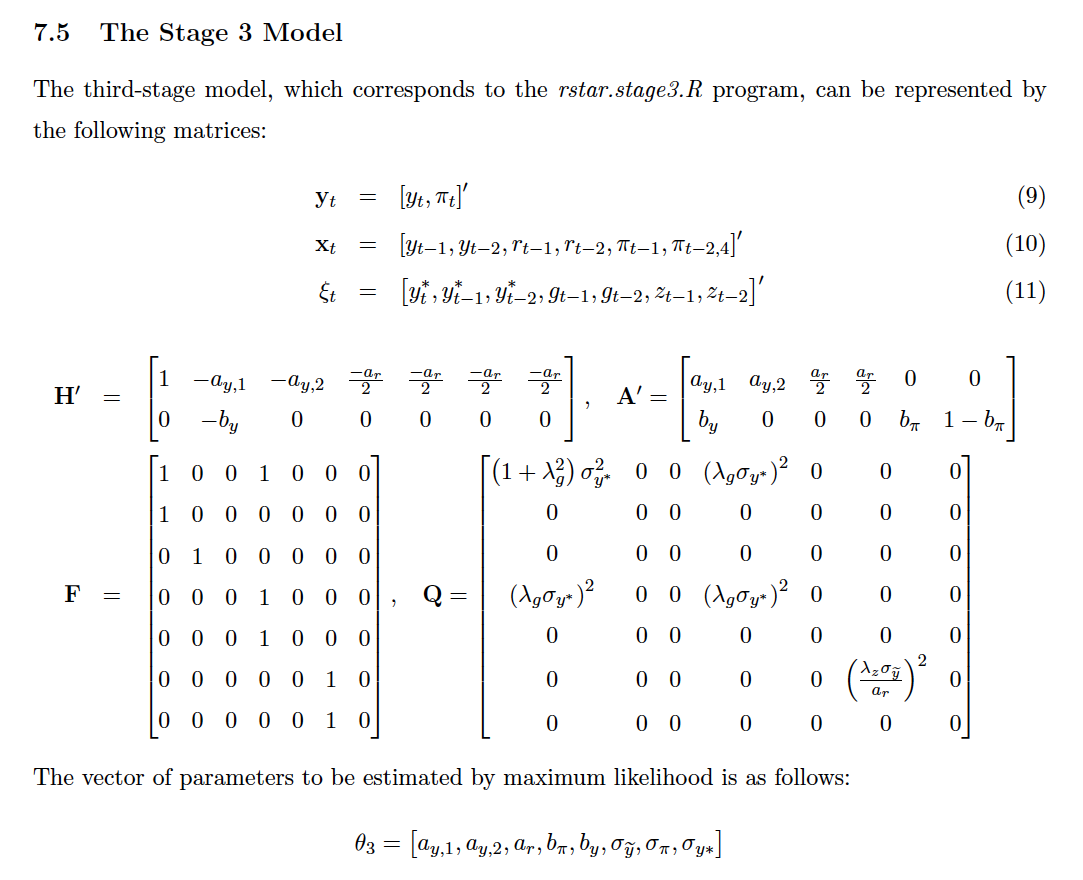

- Impose the estimated values of $\lambda_g, \lambda_z$ from the first and second step, and estimate the remaining model parameters by maximum likelihood as described by Harvey(1989). 

In [32]:
source("unpack.parameters.stage3.R") 

In [33]:
rstar.stage3 <- function(log.output,
                         inflation,
                         real.interest.rate,
                         nominal.interest.rate,
                         lambda.g,
                         lambda.z,
                         a3.constraint=NA,
                         b2.constraint=NA,
                         run.se = TRUE) {

  stage <- 3
  
  # Data must start 4 quarters before the estimation period
  T <- length(log.output) - 4

  # Original output gap estimate
  x.og <- cbind(rep(1,T+4), 1:(T+4))
  y.og <- log.output
  output.gap <- (y.og - x.og %*% solve(t(x.og) %*% x.og, t(x.og) %*% y.og)) * 100

  # Initialization of state vector for Kalman filter using HP trend of log output
  log.output.hp.trend <- hpfilter(log.output,freq=36000,type="lambda",drift=FALSE)$trend
  g.pot <- log.output.hp.trend[(g.pot.start.index):length(log.output.hp.trend)]
  g.pot.diff <- diff(g.pot)
  xi.00 <- c(100*g.pot[3:1],100*g.pot.diff[2:1],0,0)

  # IS curve
  y.is <- output.gap[5:(T+4)]
  x.is <- cbind(output.gap[4:(T+3)], output.gap[3:(T+2)],
                (real.interest.rate[4:(T+3)] + real.interest.rate[3:(T+2)])/2,
                rep(1,T))
  b.is <- solve(t(x.is) %*% x.is, t(x.is) %*% y.is)
  r.is <- as.vector(y.is - x.is %*% b.is)
  s.is <- sqrt(sum(r.is^2) / (length(r.is)-(dim(x.is)[2])))

  # Phillips curve
  y.ph <- inflation[5:(T+4)]
  x.ph <- cbind(inflation[4:(T+3)],
                (inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/3,
                output.gap[4:(T+3)])
  b.ph <- solve(t(x.ph) %*% x.ph, t(x.ph) %*% y.ph)
  r.ph <- y.ph - x.ph %*% b.ph
  s.ph <- sqrt(sum(r.ph^2) / (length(r.ph)-(dim(x.ph)[2])))
  
  y.data <- cbind(100 * log.output[5:(T+4)],
                  inflation[5:(T+4)])
  x.data <- cbind(100 * log.output[4:(T+3)],
                  100 * log.output[3:(T+2)],
                  real.interest.rate[4:(T+3)],
                  real.interest.rate[3:(T+2)],                  
                  inflation[4:(T+3)],
                  (inflation[3:(T+2)]+inflation[2:(T+1)]+inflation[1:T])/3)

  # Starting values for the parameter vector  
  initial.parameters <- c(b.is[1:3], b.ph[1], b.ph[3], s.is, s.ph, 0.7) 

  # Set an upper and lower bound on the parameter vectors:
  # The vector is unbounded unless values are otherwise specified  
  theta.lb <- c(rep(-Inf,length(initial.parameters)))
  theta.ub <- c(rep(Inf,length(initial.parameters)))

  # Set a lower bound for the Phillips curve slope (b_2) of b2.constraint, if not NA
  # In HLW, b2.constraint = 0.025  
  if (!is.na(b2.constraint)) {
      print(paste0("Setting a lower bound on b_2 of ",as.character(b2.constraint)))
      if (initial.parameters[5] < b2.constraint) {
          initial.parameters[5] <- b2.constraint
      }
      theta.lb[5] <- b2.constraint
  }

  # Set an upper bound for the IS curve slope (a_3) of a3.constraint, if not NA
  # In HLW, a3.constraint = -0.0025  
  if (!is.na(a3.constraint)) {
      print(paste0("Setting an upper bound on a_3 of ",as.character(a3.constraint)))
      if (initial.parameters[3] > a3.constraint) {
          initial.parameters[3] <- a3.constraint
      }
      theta.ub[3] <- a3.constraint      
  }

  # Set the initial covariance matrix (see footnote 6)   
  P.00 <- calculate.covariance(initial.parameters, theta.lb, theta.ub, y.data, x.data, stage, lambda.g, lambda.z, xi.00)
  
  # Get parameter estimates via maximum likelihood
  f <- function(theta) {return(-log.likelihood.wrapper(theta, y.data, x.data, stage, lambda.g, lambda.z, xi.00, P.00)$ll.cum)}
  nloptr.out <- nloptr(initial.parameters, f, eval_grad_f=function(x) {gradient(f, x)},
                       lb=theta.lb,ub=theta.ub,
                       opts=list("algorithm"="NLOPT_LD_LBFGS","xtol_rel"=1.0e-8))
  theta <- nloptr.out$solution
  
  log.likelihood <- log.likelihood.wrapper(theta, y.data, x.data, stage, lambda.g, lambda.z, xi.00, P.00)$ll.cum

  # Get state vectors (xi.tt, xi.ttm1, xi.tT, P.tt, P.ttm1, P.tT) via Kalman filter
  states <- kalman.states.wrapper(theta, y.data, x.data, stage, lambda.g, lambda.z, xi.00, P.00)

  # If run.se = TRUE, compute standard errors for estimates of the states (see footnote 7) and report run time
  if (run.se) {
      ptm <- proc.time()
      se <- kalman.standard.errors(T, states, theta, y.data, x.data, stage, lambda.g, lambda.z, xi.00, P.00, niter, a3.constraint, b2.constraint)
      print("Standard error procedure run time")
      print(proc.time() - ptm)
  }
  
  # One-sided (filtered) estimates
  trend.filtered      <- states$filtered$xi.tt[,4] * 4
  z.filtered          <- states$filtered$xi.tt[,6]
  rstar.filtered      <- trend.filtered + z.filtered
  potential.filtered  <- states$filtered$xi.tt[,1]/100
  output.gap.filtered <- y.data[,1] - (potential.filtered * 100)

  # Two-sided (smoothed) estimates
  trend.smoothed      <- states$smoothed$xi.tT[,4] * 4
  z.smoothed          <- states$smoothed$xi.tT[,6]
  rstar.smoothed      <- trend.smoothed + z.smoothed
  potential.smoothed  <- states$smoothed$xi.tT[,1]/100
  output.gap.smoothed <- y.data[,1] - (potential.smoothed * 100)
   
  # Save variables to return
  return.list <- list()
  return.list$rstar.filtered      <- rstar.filtered
  return.list$trend.filtered      <- trend.filtered
  return.list$z.filtered          <- z.filtered
  return.list$potential.filtered  <- potential.filtered
  return.list$output.gap.filtered <- output.gap.filtered
  return.list$rstar.smoothed      <- rstar.smoothed
  return.list$trend.smoothed      <- trend.smoothed
  return.list$z.smoothed          <- z.smoothed
  return.list$potential.smoothed  <- potential.smoothed
  return.list$output.gap.smoothed <- output.gap.smoothed
  return.list$theta               <- theta
  return.list$log.likelihood      <- log.likelihood
  return.list$states              <- states
  return.list$xi.00               <- xi.00
  return.list$P.00                <- P.00
  return.list$y.data              <- y.data
  return.list$initial.parameters  <- initial.parameters
  if (run.se) { return.list$se    <- se }
  return(return.list)
}


In [34]:
# # If singular issue appears
# kalman.states.smoothed <- function(xi.ttm1.array, P.ttm1.array, xi.tt.array, P.tt.array,
#                                   F, Q, A, H, R, y, x, t=dim(y)[1], xi.tp1T=NA, P.tp1T=NA) {
#   n <- dim(xi.ttm1.array)[2]
#   if (t == dim(y)[1]) {
#     xi.tT <- xi.tt.array[t,]
#     P.tT <- P.tt.array[((t-1)*n+1):(t*n),]
#     tmp <- kalman.states.smoothed(xi.ttm1.array, P.ttm1.array, xi.tt.array, P.tt.array,
#                                   F, Q, A, H, R, y, x, t-1, xi.tT, P.tT)
#     return(list("xi.tT"=rbind(tmp$xi.tT, xi.tT),
#                 "P.tT" =rbind(tmp$P.tT, P.tT)))
#   } else {
#     P.tt <- P.tt.array[((t-1)*n+1):(t*n),]
#     P.tp1t <- P.ttm1.array[(t*n+1):((t+1)*n),]

#     # Singular issue - regularization
#     J.t <- P.tt %*% t(F) %*% solve(P.tp1t + 1e-8 * diag(n))
#     # J.t <- P.tt %*% t(F) %*% solve(P.tp1t)
    
#     xi.tt <- xi.tt.array[t,]
#     xi.tp1t <- xi.ttm1.array[t+1,]
#     xi.tT <- xi.tt + as.vector(J.t %*% (xi.tp1T - xi.tp1t))
#     P.tT <- P.tt + J.t %*% (P.tp1T - P.tp1t) %*% t(J.t)
#     if (t > 1) {
#       tmp <- kalman.states.smoothed(xi.ttm1.array, P.ttm1.array, xi.tt.array, P.tt.array,
#                                     F, Q, A, H, R, y, x, t-1, xi.tT, P.tT)
#       return(list("xi.tT"=rbind(tmp$xi.tT, xi.tT),
#                   "P.tT" =rbind(tmp$P.tT, P.tT)))
#     } else {
#       return(list("xi.tT"=xi.tT, "P.tT"=P.tT))
#     }
#   }
# }

In [35]:
# Running the stage 3 model
out.stage3 <- rstar.stage3(log.output,
    inflation,
    real.interest.rate,
    nominal.interest.rate,
    lambda.g,
    lambda.z,
    a3.constraint,
    b2.constraint,
    run.se)

[1] "Setting a lower bound on b_2 of 0.025"
[1] "Setting an upper bound on a_3 of -0.0025"
[1] "Computing Standard Errors"
[1] "Standard Error Procedure: a3.constraint"
[1] -0.0025
[1] "Standard Error Procedure: b2.constraint"
[1] 0.025


Warning message in rm(.Random.seed):
"object '.Random.seed' not found"


[1] "Standard error procedure run time"
   user  system elapsed 
 71.657   3.732  75.738 


In [36]:
estimation <- list(out.stage1=out.stage1,out.stage2=out.stage2,out.stage3=out.stage3,
                lambda.g=lambda.g,lambda.z=lambda.z)

In [37]:
# One-sided (filtered) estimates
one.sided.est <- cbind(out.stage3$rstar.filtered,
                        out.stage3$trend.filtered,
                        out.stage3$z.filtered,
                        out.stage3$output.gap.filtered)

In [38]:
output <- format.output(estimation, one.sided.est, real.interest.rate, sample.start, sample.end, run.se = run.se)

In [39]:
# Save output to CSV
library(stringr)
file.name <- paste('output/',data.start[1],'Q',data.start[2],'_',data.end[1],'Q',data.end[2],'_',inf,'_',int,'_','250409.csv')
file.name <- str_replace_all(file.name," ","")
write.table(output, file.name, col.names = output.col.names, quote=FALSE, row.names=FALSE, sep = ',', na = '')

# 4. Visualization

In [40]:
library(zoo)

sample.start.date <- as.Date(as.yearqtr(paste(sample.start[1], sample.start[2], sep = " Q"), format = "%Y Q%q"))


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




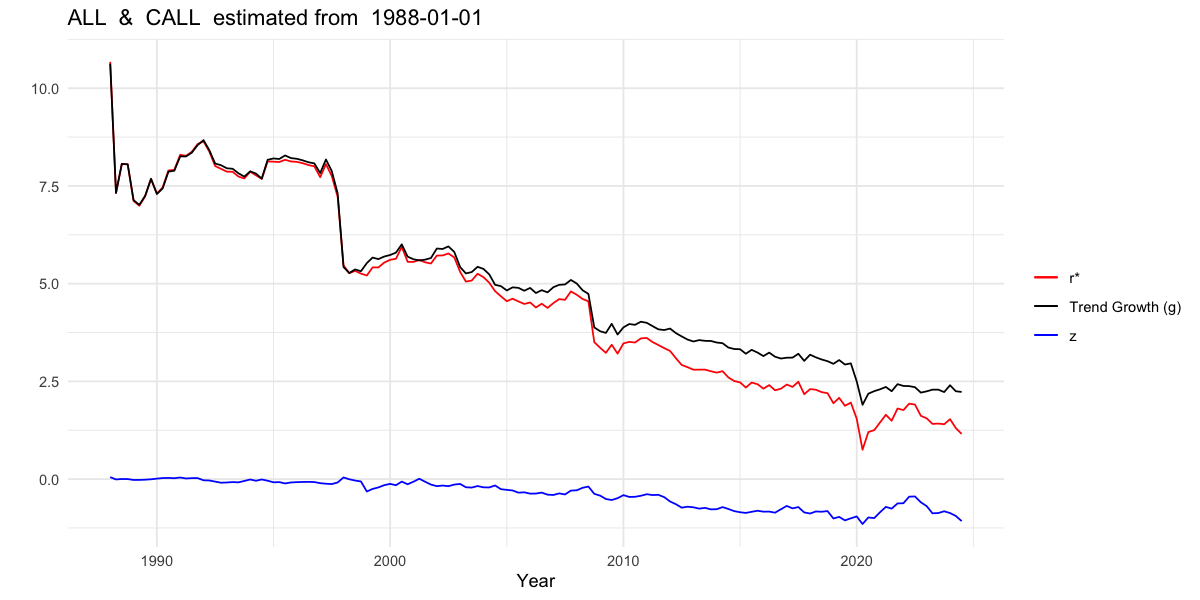

In [41]:
quarter_dates <- seq(sample.start.date, by = "quarter", length.out = length(out.stage3$rstar.filtered))

df <- data.frame(Year = quarter_dates,
               r_star = out.stage3$rstar.filtered,
               Trend_Growth_g = out.stage3$trend.filtered,
               shock = out.stage3$z.filtered)

options(repr.plot.width=10, repr.plot.height=5)

library(ggplot2)
ggplot(data = df, aes(x = Year)) +
     geom_line(aes(y = r_star, color = "r*")) +
     geom_line(aes(y = Trend_Growth_g, color = "Trend Growth (g)")) +
     geom_line(aes(y = shock, color = "z")) +
     labs(title = paste(inf, " & ", int, " estimated from ", sample.start.date),
          y = "", x = "Year") +
     scale_color_manual(values = c("r*" = "red", "Trend Growth (g)" = "black", "z" = "blue"), 
                         name = "", 
                         breaks = c("r*", "Trend Growth (g)", "z")) +
     scale_linetype_manual(values = c("Trend Growth (g)" = "dotted"), 
                         name = "", 
                         breaks = "Trend Growth (g)") +
theme_minimal() 

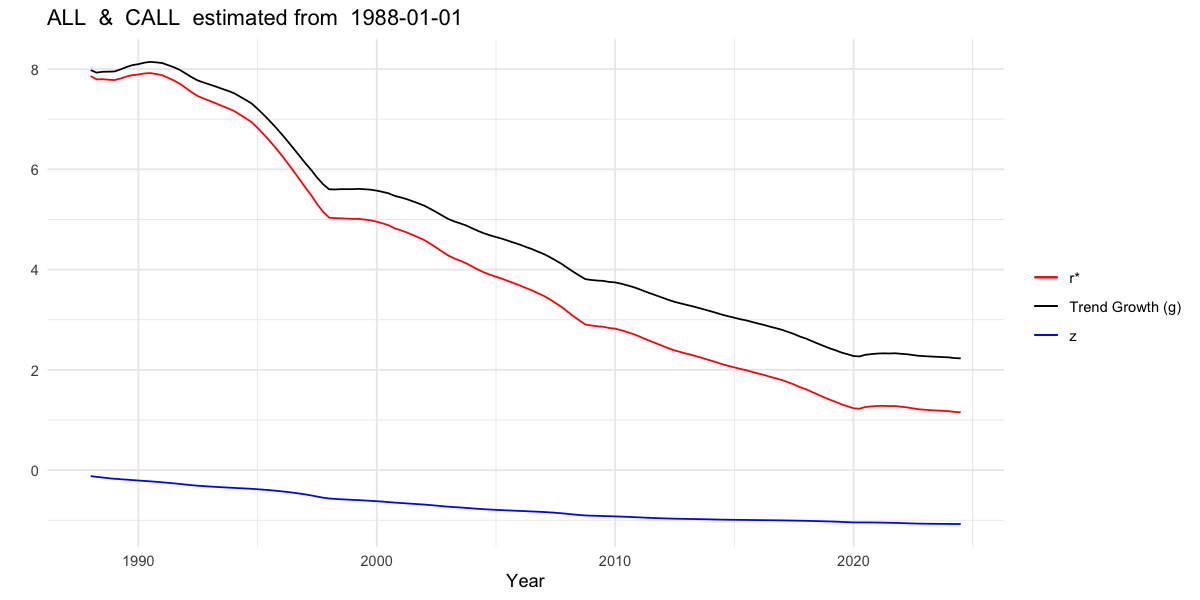

In [42]:
quarter_dates <- seq(sample.start.date, by = "quarter", length.out = length(out.stage3$rstar.smoothed))

df <- data.frame(Year = quarter_dates,
               r_star = out.stage3$rstar.smoothed,
               Trend_Growth_g = out.stage3$trend.smoothed,
               shock = out.stage3$z.smoothed)

options(repr.plot.width=10, repr.plot.height=5)

library(ggplot2)
ggplot(data = df, aes(x = Year)) +
     geom_line(aes(y = r_star, color = "r*")) +
     geom_line(aes(y = Trend_Growth_g, color = "Trend Growth (g)")) +
     geom_line(aes(y = shock, color = "z")) +
     labs(title = paste(inf, " & ", int, " estimated from ", sample.start.date),
          y = "", x = "Year") +
     scale_color_manual(values = c("r*" = "red", "Trend Growth (g)" = "black", "z" = "blue"), 
                         name = "", 
                         breaks = c("r*", "Trend Growth (g)", "z")) +
     scale_linetype_manual(values = c("Trend Growth (g)" = "dotted"), 
                         name = "", 
                         breaks = "Trend Growth (g)") +
theme_minimal() 